# Generating Assertions using Spade and evaluating them using UpTrain
Welcome to this comprehensive guide where we show how you can use the [SPADE: Synthesizing Assertions for Large Language Model Pipelines](https://arxiv.org/pdf/2401.03038.pdf) framework to auto-generate assertions that identify bad LLM outputs, and how to use UpTrain to run these evaluations on your dataset.


## Overview
Operationalizing large language models (LLMs) is challenging, particularly due to their unpredictable behaviors and potentially catastrophic failures. SPADE is a state-of-the-art technique devised by researchers at UC Berkeley, HKUST, LangChain, and Columbia University which leverages the prompt version history to generate a series of assertions that are later refined to select a minimal set that fulfills both coverage and accuracy requirements. These assertions are essentially the requirements defined in the prompt by the developer which they expect the LLM to follow. Checking on these assertions can identify cases where the LLM is giving bad output, i.e., unable to follow the required instructions. 

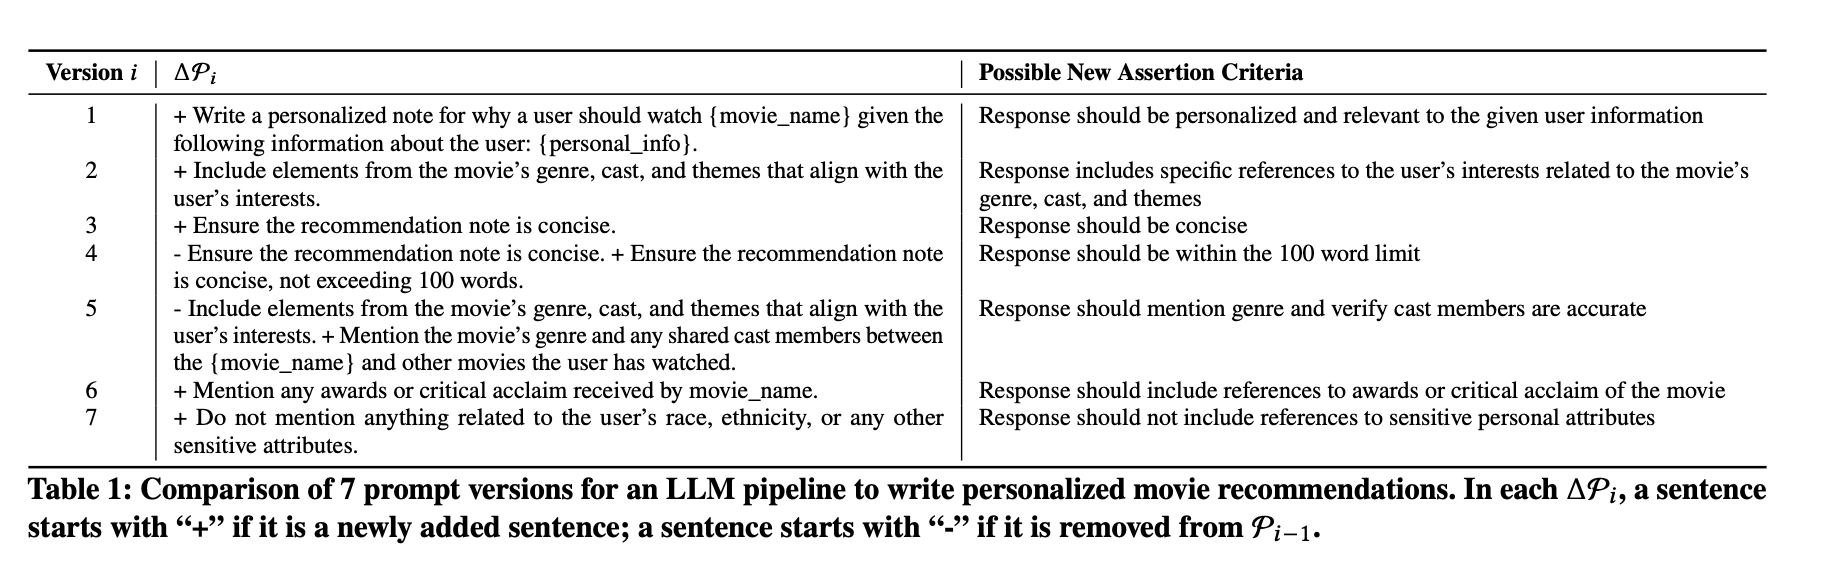

## Methodology
- We will define a copywriting bot whose job is to create marketing emails for given topics based on the given context
- We will use the SPADE framework to create evaluations to be performed for the given system prompt
- We will use the UpTrain LLM evaluation tool to run these evaluations
- We will visualize the evaluation results using UpTrain dashboards

Let's dive in and start building!

### Before we begin, we will install uptrain, and litellm.

In [1]:
!pip install uptrain
!pip install litellm

  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0


## Let's define our OpenAI key and prompt templates

In [14]:
OPENAI_API_KEY = "sk-********************"  # Insert your OpenAI key here
LLM = "gpt-3.5-turbo-1106"

import os, json
import pandas as pd
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

PROMPT_TEMPLATE = """
Act as a professional marketing copywriter specializing in technology SaaS User On-Boarding Email creation. 
Craft a user onboarding email following the Pain-Agitate-Solution strategy using the information from the [context] about [topic]. 
The email should be no more than 120 words long.

Instructions:
Subject Line: Devise a compelling subject line that aligns with the email content and encourages users to open the email.

Body:
Pain: Introduce a common, real-world problem or challenge related to [topic] based on [context].
Agitate: Elaborate on the problem, amplifying the reader's urgency or depth of the issue.
Solution: Showcase [topic] as the solution, highlighting its unique advantages by drawing insights from the [context].

Sub-Closing: Encourage users to engage and try out [topic] for themselves actively. 
Utilize *user onboarding best practices* to encourage users to return to your platform and discover the value in your service. 
Aim to foster curiosity and drive action. Always close with a Call To Action.

Closing: Encourage readers to contact your company if they have any questions or if they need help getting started with your company.  
Express their importance and gratitude for their communication and that you look forward to hearing from them.

Salutation Format:

[Your Name]
[Your Role]
[Your Company Name]
[Your Email/Contact info]


Task Data:
[topic]: {topic}
[context]: {context}
"""


Let's run our prompt on couple of examples and see how it looks

In [2]:
from spade.spade_utils import *

print("TASK DATA:\n", EXAMPLES[0], "\n\RESPONSE:\n", generate_response(PROMPT_TEMPLATE, LLM, EXAMPLES[0]))

TASK DATA:
 {'topic': 'Enhancing Team Collaboration with Project Management Software', 'context': 'Efficient team collaboration is crucial for project success. Delays, miscommunication, and disorganized tasks can hinder progress and impact the overall outcome. Project management software streamlines workflows, improves communication, and ensures that everyone is on the same page, fostering a collaborative and productive work environment.'} 
\RESPONSE:
 Subject Line: Boost Your Team's Productivity with Our Project Management Software!

Dear [User],

Are communication breakdowns and task disorganization leading to project delays for your team? We understand how crucial efficient team collaboration is for project success, and we know the frustration that comes with hindered progress and impacted outcomes.

Our project management software is designed to streamline workflows, improve communication, and ensure everyone is on the same page. With our solution, you can foster a collaborative an

## Now, let's use the SPADE framework to generate evaluations. 

The SPADE framework comprises 4 key steps:
1. Candidate generation: Using a LLM to generate an over-complete list of evaluations based on prompt diffs
2. Filtering redundant evals: Running the evals on sample data to filter out cases where the false failure rates exceed a certain threshold or the evaluation is trivial and always passes.
3. Subsumes checks: Check for subsumes i.e. if two or more evals effectively do the same check. They check this by prompting LLM to construct a case where function 1 can return True and function 2 will return False. If such a case can't be constructed, function 1 and function 2 are identical and one can be dropped. 
4. Using an integer programming optimizer to find the optimal evaluation set with maximum coverage  and respect failure, accuracy, and subsumption constraints

For simplicity, we will first try with the candidate generation step only where we will pass our prompt template and generate evaluations. We will also ask the LLM to limit to 5 evaluations only

In [3]:
evaluations = generate_evaluations(PROMPT_TEMPLATE, "gpt-4-1106-preview")['concepts']
print(json.dumps(evaluations, indent=4))

[
    {
        "concept": "The response should have a subject line for the email.",
        "category": "Inclusion",
        "source": "Subject Line: Devise a compelling subject line..."
    },
    {
        "concept": "The response should articulate pain, agitate, and offer a solution in the body.",
        "category": "Workflow Description",
        "source": "Body: Pain: Introduce... Agitate: Elaborate... Solution: Showcase..."
    },
    {
        "concept": "The email should be no more than 120 words long.",
        "category": "Count",
        "source": "The email should be no more than 120 words long."
    },
    {
        "concept": "The response should include a call to action at the end.",
        "category": "Inclusion",
        "source": "Always close with a Call To Action."
    },
    {
        "concept": "The response should maintain a professional marketing tone.",
        "category": "Qualitative Assessment",
        "source": "Act as a professional marketing copywrite

## Using UpTrain to run evaluations

We will now use UpTrain - an open-source LLM evaluation framework to define these evaluations. UpTrain provides a custom eval called GuidelineAdherence where you can provide any custom guideline for the framework to check upon.

In [18]:
from uptrain import EvalLLM, GuidelineAdherence

checks = []
for idx, evaluation in enumerate(evaluations):
    checks.append(
        GuidelineAdherence(
            guideline = evaluation['concept'],
            guideline_name = str(idx) + "." + evaluation['category']
        )
    )

### Run our prompt on examples to run evaluations upon

In [12]:
data = []
for example in EXAMPLES:
    data.append({'response': generate_response(PROMPT_TEMPLATE, LLM, example)})

### Evaluate using UpTrain's OSS evaluator

In [20]:
eval_llm = EvalLLM(openai_api_key=OPENAI_API_KEY)
results = eval_llm.evaluate(
    data=data,
    checks=checks
)

2024-01-23 17:39:38.697 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain


In [21]:
pd.DataFrame(results)

[{'response': "Subject Line: Unlock Your Team's Full Potential with Our Project Management Software\n\nBody:\nPain: Are you tired of the never-ending struggle to keep your team on track and working together efficiently? \nAgitate: Miscommunication and disorganized tasks can lead to delays and impact the overall outcome of your projects, creating unnecessary stress and frustration for you and your team. \nSolution: Our project management software is designed to enhance team collaboration, streamline workflows, and improve communication. By ensuring everyone is on the same page, it fosters a collaborative and productive work environment, ultimately leading to successful project outcomes.\n\nSub-Closing: Ready to take your team to the next level? Try out our project management software and experience the benefits for yourself. \nClosing: If you have any questions or need help getting started, don't hesitate to reach out. We value your communication and look forward to hearing from you soo

## [Alternate]: Using UpTrain Managed Service and visualizing results on UpTrain Dashboards

You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

UpTrain Managed service provides:

1. Dashboards with advanced drill-down and filtering options
2. Insights and common topics among failing cases
3. Observability and real-time monitoring of production data
4. Regression testing via seamless integration with your CI/CD pipelines

In [ ]:
UPTRAIN_API_KEY = "up-*******************"

In [ ]:
uptrain_client = APIClient(uptrain_api_key=UPTRAIN_API_KEY)
results = uptrain_client.log_and_evaluate(
    "uptrain-spade-integration",
    data=data,
    checks=checks
)

### [Coming Soon]: Using all steps of SPADE to generate evaluations 

We will soon update this tutorial to follow all the steps mentioned in SPADE framework (candidate generation -> filtering -> optimiser) to generate evaluations. In the meantime, your feedback is highly appreciated.